In [1]:
import os
os.chdir('../')

In [2]:
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scanpy as sc
import sklearn
from io import StringIO
from ana_utils import *
from data_struct import scData
from Bio import Phylo
import re

from ete3 import Tree
from matplotlib.colors import ListedColormap

from inference import velocity_inference
from embedding import velocity_embedding

In [3]:
"""
1. embryo3
"""
ldata = scv.read("../datas/embryo/embryo3/embryo3out.loom", cache=True)
ldata.var_names_make_unique
selected = pd.read_csv("../datas/embryo/embryo3/scRNA_metadata_blood_development.csv", 
                       usecols=["cell","orig.ident","cluster"])

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 29008 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/160 cores)



    finished (0:00:50) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/160 cores)



    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


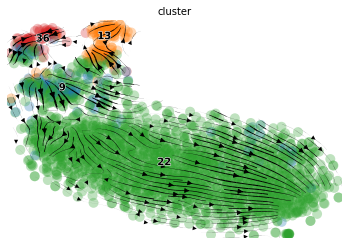

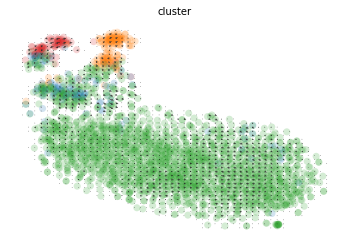

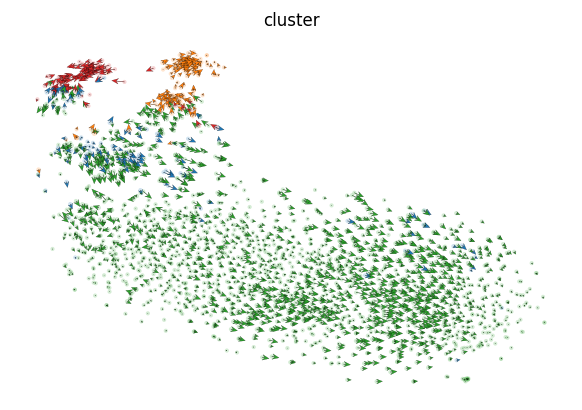

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


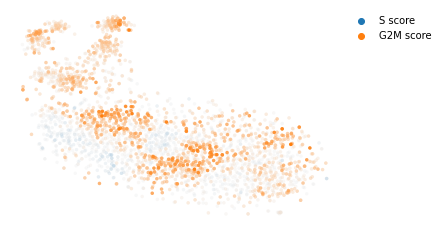

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


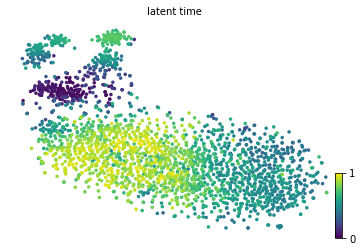

In [4]:

selected["cell.id"]=selected["orig.ident"].str.split('_').str[-1]+str("out")+str(":")+selected["cell"]+"x"
ldata1 = ldata[np.isin(ldata.obs.index, selected["cell.id"])]
s1 = selected.iloc[:,[3,2]]
s1.columns=["CellID","cluster"]
s1=s1.set_index("CellID")
s2 = ldata1.obs
ldata1.obs=pd.merge(s2,s1,left_index=True,right_index=True,how="left")

nam = "embryo3_blood"

"""
Process the data
"""
# scv.pp.filter_genes(ldata1, min_shared_counts=20)
# scv.pp.normalize_per_cell(ldata1)
# scv.pp.filter_genes_dispersion(ldata1, n_top_genes=2000)
# scv.pp.log1p(ldata1)
scv.pp.filter_and_normalize(ldata1,min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(ldata1,n_pcs=30, n_neighbors=30)  #calculate the first and second order moments

"""
Estimate RNA velocity
"""
scv.tl.recover_dynamics(ldata1)
scv.tl.velocity(ldata1, mode="dynamical")
scv.tl.velocity_graph(ldata1)
scv.tl.tsne(ldata1)
#scv.tl.umap(ldata1)
scv.tl.louvain(ldata1)

"""
Project the velocities
"""
#scv.pl.velocity_embedding_stream(ldata1, basis='umap')
scv.pl.velocity_embedding_stream(ldata1, basis='X_tsne',color="cluster")#,ax=ax[0,0], show=False
scv.pl.velocity_embedding_grid(ldata1, basis='X_tsne',color="cluster")#,ax=ax[0,1], show=False
scv.pl.velocity_embedding(ldata1, arrow_length=3, arrow_size=2,color="cluster", dpi=120)#,ax=ax[1,0], show=False
#scv.tl.latent_time(ldata1)
#scv.pl.scatter(ldata1, color='latent_time', color_map='gnuplot', size=80)
""""
Velocities in cycling progenitors
"""
scv.tl.score_genes_cell_cycle(ldata1)
scv.pl.scatter(ldata1, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])
""""
Velocity graph and pseudotime
"""
scv.tl.latent_time(ldata1)
scv.pl.scatter(ldata1, color='latent_time', cmap='viridis')

In [5]:
tree = Phylo.read('../datas/embryo/trees/embryo3_blood.newick', 'newick')

# tree = Phylo.read('../datas/embryo/trees/embryo6_all.newick', 'newick')

from ete3 import Tree
from io import StringIO

with open('../datas/embryo/trees/embryo3_blood.newick', 'r') as f:
    tree_nwk = f.readline()
t = Tree(tree_nwk)
f = StringIO(t.write())
tree = Phylo.read(f, 'newick')
f.close()



In [6]:
cell_names = list(set(ldata1.obs_names).intersection(set([f'embryo3out:{i.name}x' for i in tree.get_terminals()])))

In [7]:
count = ldata.X.A[np.isin(ldata.obs_names, cell_names)]

In [8]:
sd = scData()
sd.phylo_tree = tree
sd.cell_names = cell_names
sd.count = pd.DataFrame(data=count, columns=ldata.var_names, index=cell_names)
sd.Xdr = pd.DataFrame(data=ldata1.obsm['X_tsne'], index=ldata1.obs_names)
sd.Xdr = sd.Xdr.loc[sd.cell_names]
sd.cell_states = [int(selected[selected['cell']==re.findall('[ATCG]+', i)[0]].cluster) for i in sd.cell_names]

In [9]:
scv.pp.filter_and_normalize(ldata,min_shared_counts=10)
x_normed = pd.DataFrame(data = ldata.X.A, columns=ldata.var_names, index=ldata.obs_names)
sd.x_normed = x_normed.loc[sd.cell_names]
sd.x_normed = sd.x_normed.loc[:, sd.x_normed.sum(axis=0)>0]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 23457 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [10]:
sd.drop_duplicate_genes(target='x_normed')

In [11]:
depths = [sd.phylo_tree.depths()[sd.phylo_tree.find_any(name=re.findall('[ATCG]+', i)[0])] for i in sd.count.index]

In [13]:
sd = velocity_inference(sd, depths, cutoff=0.97, target='x_normed')

In [14]:
sd = velocity_embedding(sd, target='x_normed')

In [15]:
cmap = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# cmap = ListedColormap(['tab:blue', 'tab:red', 'tab:orange', 'tab:green'])
color_map = dict(zip([9,36,13,22], [0, 3, 1, 2]))
state_map = dict(zip([9,36,13,22,32], ['primitive blood early', 'primitive blood progenitors', 'hematopoietic/endothelial progenitors', 'primitive blood late', 'angioblasts']))

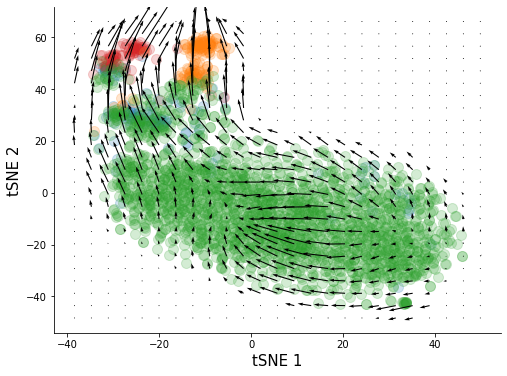

In [16]:
fig, ax = plt.subplots()
for i in set(sd.cell_states):
    ax.scatter(sd.Xdr.iloc[np.array(sd.cell_states)==i, 0], sd.Xdr.iloc[np.array(sd.cell_states)==i, 1], c=cmap[color_map[i]], s=100, alpha=0.2, label=state_map[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'grid', grid_density=25, radius=8, lw_coef=1)
ax.figure.set_size_inches(8,6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('./figures/embryo3_blood/grid.pdf', dpi='figure', format='pdf')

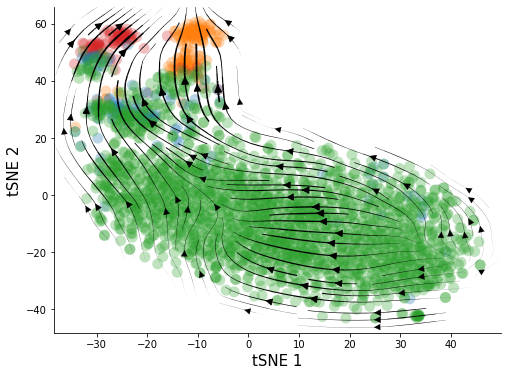

In [44]:
fig, ax = plt.subplots()
for i in [13,36,9,22]:
    ax.scatter(sd.Xdr.iloc[np.array(sd.cell_states)==i, 0], sd.Xdr.iloc[np.array(sd.cell_states)==i, 1], c=cmap[color_map[i]], edgecolors='none', s=120, alpha=0.3, label=state_map[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.5, radius=5, lw_coef=8000, arrowsize=1.5)
ax.figure.set_size_inches(8, 6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
# ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('./figures/embryo3_blood/stream.pdf', dpi='figure', format='pdf')

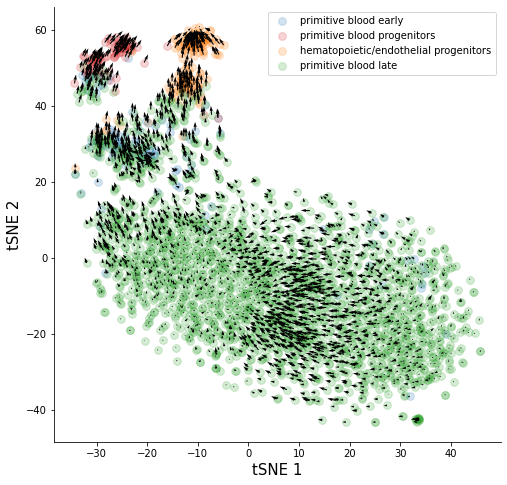

In [18]:
fig, ax = plt.subplots()
for i in set(sd.cell_states):
    ax.scatter(sd.Xdr.iloc[np.array(sd.cell_states)==i, 0], sd.Xdr.iloc[np.array(sd.cell_states)==i, 1], c=cmap[color_map[i]], s=60, alpha=0.2, label=state_map[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'point',streamdensity=0.8, grid_density=25, radius=8, lw_coef=10000)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [20]:
from pseudo_time import calc_phylo_pseudotime

In [22]:
sd = calc_phylo_pseudotime(sd, n_neighbors=50, r_sample=0.4)

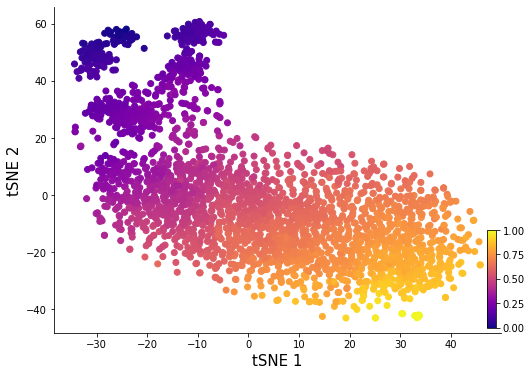

In [23]:

fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(sd.Xdr.iloc[:,0],sd.Xdr.iloc[:,1], c=sd.phylo_pseudotime,cmap='plasma')
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax, width="2%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('./figures/embryo3_blood/phylo_pseudotime.pdf', dpi='figure', format='pdf')

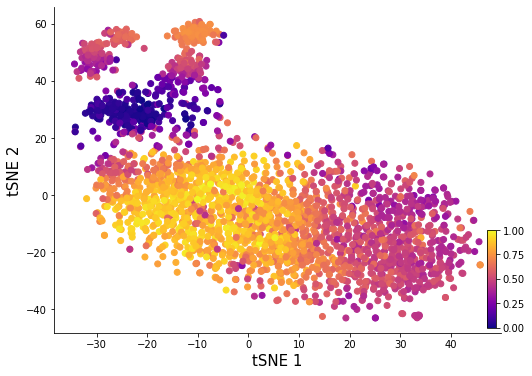

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(sd.Xdr.iloc[:,0],sd.Xdr.iloc[:,1], c=ldata1.obs.latent_time[sd.Xdr.index],cmap='plasma')
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax, width="2%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('./figures/embryo3_blood/scVelo_latenttime.pdf', dpi='figure', format='pdf')

Text(0, 0.5, 'Fraction')

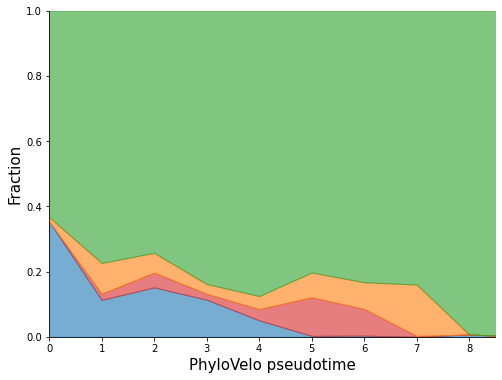

In [30]:
phytime_bar = dict()
for i in state_map:
    phytime_bar[state_map[i]] = ldata1.obs.latent_time[sd.Xdr.index].to_numpy()[np.where(np.array(sd.cell_states)==i)]
hist_data = []
hist_labels = []
hist_colors = []
for i in set(sd.cell_states):
    hist_data.append(phytime_bar[state_map[i]])
    hist_labels.append(state_map[i])
    hist_colors.append(cmap[color_map[i]])
    
hd = ax.hist(hist_data, label=hist_labels, color=hist_colors,alpha=0.7)
fig, ax = plt.subplots(figsize=(8,6))
mullerplot(hd[0],hist_labels, hist_colors, absolute=0,alpha=0.6, ax=ax)
ax.set_xlim(0, 8.5)
ax.set_ylim(0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('PhyloVelo pseudotime', font='Arial', fontsize=15)
ax.set_ylabel('Fraction', fontsize=15)
plt.savefig('./figures/embryo3_blood/latent_time_muller.pdf', dpi='figure', format='pdf')

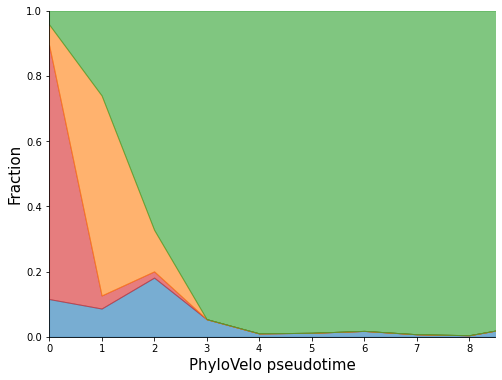

In [32]:
phytime_bar = dict()
for i in state_map:
    phytime_bar[state_map[i]] = sd.phylo_pseudotime[np.where(np.array(sd.cell_states)==i)]
hist_data = []
hist_labels = []
hist_colors = []
for i in set(sd.cell_states):
    hist_data.append(phytime_bar[state_map[i]])
    hist_labels.append(state_map[i])
    hist_colors.append(cmap[color_map[i]])
hd = ax.hist(hist_data, label=hist_labels, color=hist_colors,alpha=0.7)
fig, ax = plt.subplots(figsize=(8,6))
mullerplot(hd[0],hist_labels, hist_colors, absolute=0,alpha=0.6, ax=ax)
ax.set_xlim(0, 8.5)
ax.set_ylim(0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('PhyloVelo pseudotime', font='Arial', fontsize=15)
ax.set_ylabel('Fraction', fontsize=15)
plt.savefig('./figures/embryo3_blood/phylo_pseudotime_muller.pdf', dpi='figure', format='pdf')

In [33]:
import gseapy as gp
glist = sd.clock_genes
enr = gp.enrichr(gene_list=glist,  
                 organism='mouse', 
                 gene_sets=['GO_Biological_Process_2018'], 
                 outdir='test', 
                 top_term=20)

enr_res = enr.res2d
enr_res.Term = [i[:-13] for i in enr_res.Term]

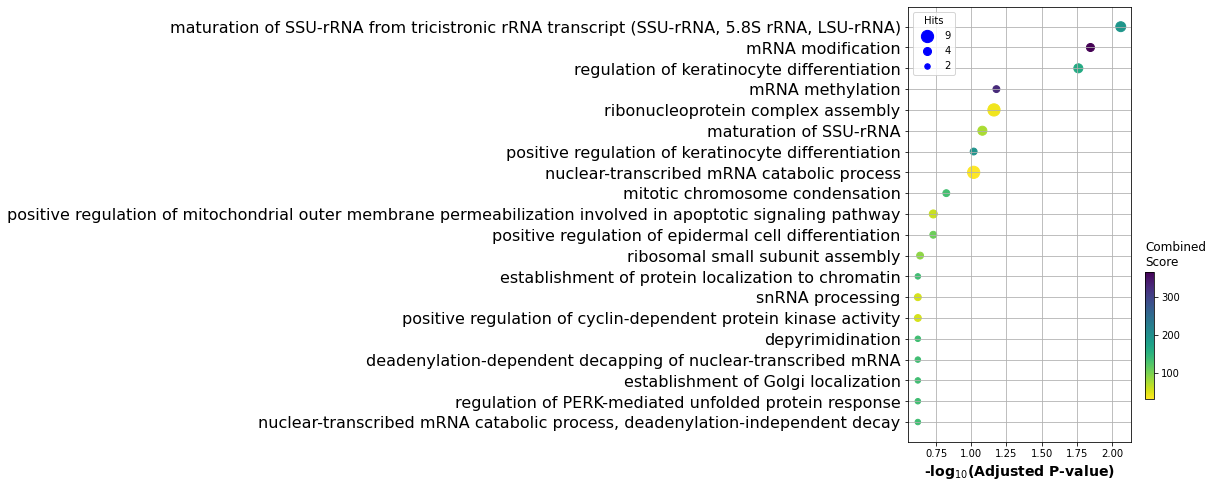

In [34]:
gp.dotplot(enr_res,cmap='viridis_r', top_term=20, cutoff=0.5, figsize=(4, 8))
plt.savefig('./figures/embryo3_blood/enrichment.pdf', dpi='figure', format='pdf')

In [91]:
from sklearn.preprocessing import scale
import seaborn as sns

gene_vel_map = pd.DataFrame(data=sd.velocity, index=sd.x_normed.columns)

genes1 = list(gene_vel_map.index[sd.velocity>0])
genes1.sort(key=lambda x:dict(zip(sd.x_normed.columns, sd.velocity))[x])
genes2 = list(gene_vel_map.index[sd.velocity<0])
genes2.sort(key=lambda x:dict(zip(sd.x_normed.columns, sd.velocity))[x])

corrs = []
genelist = []
for i in list(gene_vel_map.index[sd.velocity!=0]):
    genelist.append(i)
    x = np.array(depths)
    y = sd.x_normed[i]
    corrs.append(spearmanr(x,y)[0])
corrs = np.array(corrs)
genelist = np.array(genelist)

genes1 = genelist[corrs>0]
genes2 = genelist[corrs<0]

genes1 = genes1[np.argsort(scale(sd.x_normed[genes1], axis=0).sum(0))]
genes2 = genes2[np.argsort(scale(sd.x_normed[genes2], axis=0).sum(0))]
genes1 = genes1[::-1]


genetraj1 = []
for i in genes1:
    genetraj1.append(scale(list(sd.x_normed[i][np.argsort(sd.phylo_pseudotime)])))
genetraj1 = np.array(genetraj1)
# genetraj1 = np.log(1+genetraj1)
# genetraj1 = (genetraj1.T / np.max(genetraj1, axis=1)).T

genetraj2 = []
for i in genes2:
    genetraj2.append(scale(list(sd.x_normed[i][np.argsort(sd.phylo_pseudotime)])))
genetraj2 = np.array(genetraj2)
# genetraj2 = np.log(1+genetraj2)
# genetraj2 = (genetraj2.T / np.max(genetraj2, axis=1)).T

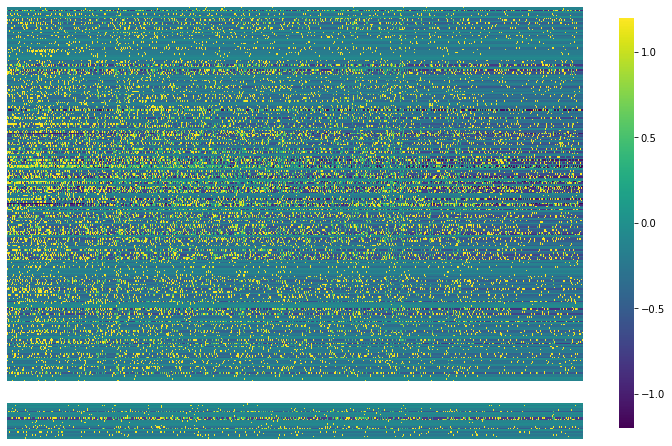

In [ ]:
fig = plt.figure(figsize=(10, 6))
h1 = len(genes1)/(len(genes1)+len(genes2))
h2 = len(genes2)/(len(genes1)+len(genes2))
ax1 = plt.axes([0.05, 0, 0.8, 0.95*h1])
ax2 = plt.axes([0.05, 0.95*h1+0.05, 0.8, 0.95*h2])
ax3 = plt.axes([0.9,0.025,0.02,0.95])

ax1 = sns.heatmap(genetraj1, cmap='viridis', ax=ax1, cbar_ax=ax3,vmax=1.2, vmin=-1.2, xticklabels=False, yticklabels='')
ax2 = sns.heatmap(genetraj2[::-1], cmap='viridis', ax=ax2, cbar=False,vmax=1.2, vmin=-1.2, xticklabels=False, yticklabels='')

# plt.savefig('./figures/EMT/heatmap_full_phylopseudotime.pdf', dpi='figure', format='pdf')

In [54]:
from scipy.stats import spearmanr

In [55]:
v_megs = pd.DataFrame(data=[sd.x_normed.columns, sd.velocity]).T
v_megs.columns = ['MEGs', 'v']
v_megs['p-value'] = v_megs['MEGs'].apply(lambda x: spearmanr(sd.x_normed[x], depths)[1])
v_megs[v_megs['v']!=0].to_csv('Blood_megs_v.csv', index=False)